<a href="https://colab.research.google.com/github/radxrad/radx-kg/blob/main/notebooks/visualization/ExampleQueries_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RADx Knowledge Graph Queries
This notebook runs queries on the radx-kg to explore the content and relationships among RADx-rad digital assets. Query results are displayed as tables, bar plots, choropleth maps, and visualized as subgraphs.

To run this notebook select ```Runtime -> Run all ``` from the menu.

The radx-kg consists of nodes and their relationships that can be queries with the [Cypher graph query language](https://neo4j.com/docs/getting-started/cypher-intro/#_getting_started_with_cypher).

<p align="center">
<img src="https://github.com/radxrad/radx-kg/blob/main/docs/Metagraph.png?raw=1", width="100%">
</p>

## Setup
This notebook installs the Neo4j Graph Database and imports the RADx-KG data and metadata. The software setup may take 2 - 3 minutes.

In [1]:
#@title Check if Notebook is running in Google Colab
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    pass

In [2]:
#@title Install software
if in_colab:
    # enable third party widgets in Colab
    from google.colab import output
    output.enable_custom_widget_manager()
    output.no_vertical_scroll()

    # copy required files (temporary solution)
    !wget -q https://raw.githubusercontent.com/pwrose/neo4j-ipycytoscape/master/notebooks/neo4j_utils.py
    !wget -q https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/neo4j_bulk_importer.py
    !wget -q https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/utils.py
    !wget -q https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/PrepareNeo4jBulkImport.ipynb

    !git clone --quiet https://github.com/radxrad/radx-kg.git

    # install software
    !apt -qq install openjdk-17-jre-headless 2>/dev/null > /dev/null
    %pip install -q papermill > /dev/null
    %pip install -q py2neo > /dev/null
    %pip install -q ipycytoscape > /dev/null
    %pip install -q python-dotenv > /dev/null
    %pip install -q plotly > /dev/null

    # set environment variables
    from dotenv import load_dotenv
    load_dotenv("/content/radx-kg/.env.colab")
else:
    # copy required files (temporary solution)
    !curl -s -O https://raw.githubusercontent.com/pwrose/neo4j-ipycytoscape/master/notebooks/neo4j_utils.py
    !curl -s -O https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/neo4j_bulk_importer.py
    !curl -s -O https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/utils.py
    !curl -s -O https://raw.githubusercontent.com/sbl-sdsc/kg-import/master/notebooks/PrepareNeo4jBulkImport.ipynb
    from dotenv import load_dotenv
    load_dotenv("../../.env", override=True)

<IPython.core.display.Javascript object>

In [3]:
#@title Imports
import os
import pandas as pd
import seaborn as sns
import plotly.express as px
from py2neo import Graph
import neo4j_utils
import neo4j_bulk_importer


pd.set_option('display.max_colwidth', None)

### Download and install Neo4j Graph Database

In [4]:
neo4j_utils.download_neo4j()

### Import the RADx-rad Knowledge Graph
CSV data and metadata files are uploaded into the Neo4j Graph database from the [kg](https://github.com/radxrad/radx-kg/tree/main/kg) directory using the [kg-import](https://github.com/sbl-sdsc/kg-import) bulk upload scripts. For a description of the data organization and the specification of metadata [see](https://github.com/sbl-sdsc/kg-import/blob/main/README.md).

In [5]:
neo4j_bulk_importer.import_from_csv();

Executing:   0%|          | 0/85 [00:00<?, ?cell/s]

Launching server....... running.


### Connect to the local Neo4j Graph database

In [6]:
database = os.environ.get("NEO4J_DATABASE")
username = os.environ.get("NEO4J_USERNAME")
password = os.environ.get("NEO4J_PASSWORD")
stylesheet = os.environ.get("NEO4J_STYLESHEET")

graph = Graph("bolt://localhost:7687", name=database, user=username, password=password)

## Table of Content
* [Metadata](#Metadata)
* [Subgraph](#Subgraph)
* [Publications](#Publications)
* [Patents](#Patents)
* [Software](#Software)
* [Presentations](#Presentations)
* [Events](#Events)
* [Organizations](#Organizations)
* [Funding Opportunities](#FundingOpportunities)
* [Grants](#Grants)

## Metadata <a class="anchor" id="Metadata"></a>

### Node metadata
radx-kg is a self-describing KG. The MetaNodes and MetaRelationships define the structure of the KG and the properties of nodes and nelationships. The query below lists the nodes in radx-kg and their properties.

In [7]:
query = """
MATCH (n:MetaNode) RETURN n;
"""
df = graph.run(query).to_data_frame()
metadata = df["n"].tolist()
metadata = pd.DataFrame(metadata)
metadata.fillna("", inplace=True)
metadata

,nodeName,name,id,url,researchInitiativeUrl,description,websites,longName,researchInitiative,narrative,...,endDate,city,eventUrl,eventType,state,startDate,geonames,ror,uei,duns
0,FundingOpportunity,Name of the funding opportunity (string),Unique identifier for the funding opportunity (Thesaurus:C20021) (string),URL to funding opportunity description (string),,,,,,,...,,,,,,,,,,
1,ResearchInitiative,Abbreviation of the research initiative (string),Unique id of the research initiative (string),URL of the research initiative website (string),Description of the research initiative that funded the research initiative (string),Description of the research initiative (string),URLs of related websites (string[]),Long name for research initiative (string),,,...,,,,,,,,,,
2,Grant,Title of the project (string),Unique identifier for the grant (Thesaurus:C16644) (string),,,,,,The initiative or program associated with this grant (string),Short description (string),...,,,,,,,,,,
3,Researcher,Name of the researcher (lastname plus initials) (string),Unique researcher identifier (orcid preferred or NIH profile id) (string),,,,,,,,...,,,,,,,,,,
4,Publication,Title of the publication (string),Unique identifier for the publication (string),URL of publication (string),,,,,,,...,,,,,,,,,,
5,Dataset,Name of the dataset (string),Unique identifier for the dataset (string),URL to dataset landing page (string),,,,,,,...,,,,,,,,,,
6,Presentation,Title of the presentation (string),Unique identifier of the presentation (hash of event id and name) (string),,,,,,,,...,,,,,,,,,,
7,Patent,Title of the patent (string),Identifier of the patents (string),URL of patent webpage (string),,,,,,,...,,,,,,,,,,
8,Event,Name of the event (string),Unique identifier of the event (date and event number) (string),,,,,,,,...,End data of event (date),City of event location (string),URL of the event website (string),"Type of event: webinar, virtual conference, in-person conference, hybrid conference, virtual workshop, in-person workshop, hybrid workshop (string)",State or province of the event location (string),Start date of event (date),,,,
9,Software,Name of the software application or software repository (string),Identifier of the software application or software repository (string),URL of the software application or software repository (string),,Description of the software or software repository (string),,,,,...,,,,,,,,,,


### Metagraph <a class="anchor" id="Metagraph"></a>
The metagraph shows the node labels and relationship types of the KG. Click on a node to display the node metadata.

In [8]:
query = """
MATCH p=(:MetaNode)-->(:MetaNode) RETURN p
"""
subgraph1 = graph.run(query).to_subgraph()

In [9]:
widget1 = neo4j_utils.draw_graph(subgraph1, stylesheet)
widget1.layout.height = "900px"
widget1.set_layout(name="cola", padding=40, nodeSpacing=65, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget1
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 40, 'nodeSpacing': 65, 'nodeDimensionsIncludeLabe…

### Number of Nodes

In [10]:
query = """
MATCH (n) RETURN COUNT(n);
"""
print(f"Total number of nodes: {graph.evaluate(query)}")

Total number of nodes: 4691


### Number of nodes by node label

In [11]:
query = """
MATCH (n) RETURN labels(n)[0] AS Node, COUNT(n) AS Count
ORDER BY Count DESC
"""
graph.run(query).to_data_frame()

,Node,Count
0,Researcher,2367
1,Publication,2012
2,Presentation,87
3,Organization,59
4,Dataset,50
5,Grant,48
6,Patent,17
7,FundingOpportunity,16
8,Event,14
9,MetaNode,11


### Number of relationships by relationship type

In [12]:
query = """
MATCH ()-[r]-() RETURN DISTINCT TYPE(r) AS Relationship, COUNT(r) AS Count
ORDER BY Count DESC
"""
graph.run(query).to_data_frame()

,Relationship,Count
0,AUTHORED,6946
1,CITES,4432
2,PRESENTED,348
3,IS_INVESTIGATOR_OF,228
4,USED,204
5,PRESENTED_AT,174
6,EMPLOYED_AT,166
7,PROVIDES,108
8,CREATED,106
9,SUPPORTED,94


## Subgraph for an investigator <a class="anchor" id="Subgraph"></a>

#### First neighbors in KG

In [13]:
researcher = "Cirrito"
query = """
MATCH p=(r:Researcher)--() WHERE r.lastName = $researcher RETURN p
"""
subgraph2 = graph.run(query, researcher=researcher).to_subgraph()

In [14]:
widget2 = neo4j_utils.draw_graph(subgraph2, stylesheet)
widget2.layout.height = "1000px"
widget2.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget2
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

#### First and second neighbors in KG

In [15]:
researcher = "Cirrito"
query = """
MATCH p=(r:Researcher)--()--() WHERE r.lastName = $researcher RETURN p
"""
subgraph3 = graph.run(query, researcher=researcher).to_subgraph()

In [16]:
widget3 = neo4j_utils.draw_graph(subgraph3, stylesheet)
widget3.layout.height = "1000px"
widget3.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget3
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Publications <a class="anchor" id="Publications"></a>

### Number of primary publications

In [17]:
query = """
MATCH (p:Publication) WHERE p.type = "primary" RETURN COUNT(p)
"""
print(f"Number of primary publications: {graph.evaluate(query)}")

Number of primary publications: 205


### Number of publication by RADx-rad subprojects

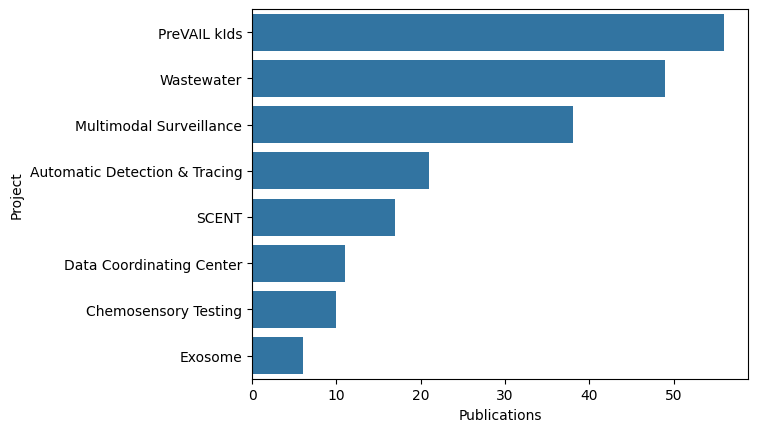

In [18]:
query = """
MATCH (p:Publication)<-[:AUTHORED]-(r:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN COUNT(DISTINCT p) AS Publications, g.subProject AS Project
ORDER BY Publications DESC
"""
publications = graph.run(query).to_data_frame()
sns.barplot(publications, x="Publications", y="Project");

### Number of secondary publications (citations)

In [19]:
query = """
MATCH (p:Publication) WHERE p.type = "secondary" RETURN COUNT(p)
"""
print(f"Number of citations: {graph.evaluate(query)}")

Number of citations: 1807


### Number of citations of the primary publications by subprojects

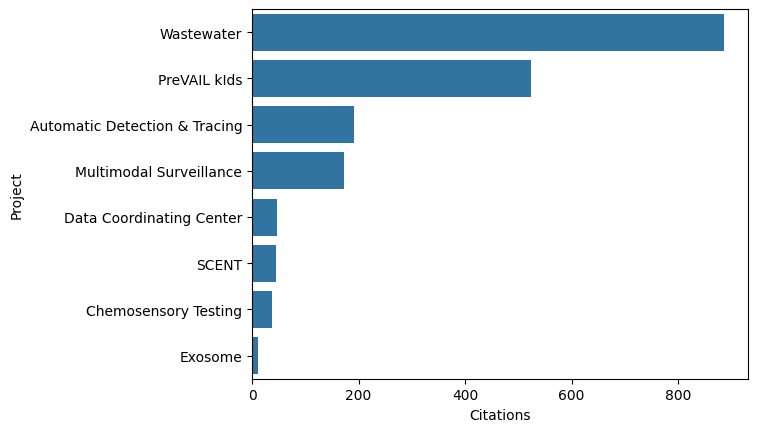

In [20]:
query = """
MATCH (p:Publication)-[CITES]->(:Publication)<-[:AUTHORED]-(:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN COUNT(DISTINCT p) AS Citations, g.subProject AS Project
ORDER BY Citations DESC
"""
citations = graph.run(query).to_data_frame()
sns.barplot(citations, x="Citations", y="Project");

### Publications authored by researcher from multiple RADx-rad grants

In [21]:
query = """
MATCH p=(g1:Grant)<-[:IS_INVESTIGATOR_OF]-(:Researcher)-[:AUTHORED]->(:Publication)<-[:AUTHORED]-(:Researcher)-[:IS_INVESTIGATOR_OF]-(g2:Grant) WHERE g1 <> g2 RETURN p
"""
subgraph4 = graph.run(query, researcher=researcher).to_subgraph()

In [22]:
widget4 = neo4j_utils.draw_graph(subgraph4, stylesheet)
widget4.layout.height = "900px"
widget4.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget4
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Patents <a class="anchor" id="Patents"></a>

### Number of patents

In [23]:
query = """
MATCH (p:Patent) RETURN COUNT(p)
"""
print(f"Number of patents: {graph.evaluate(query)}")

Number of patents: 17


### Number of patents by RADx-rad subprojects

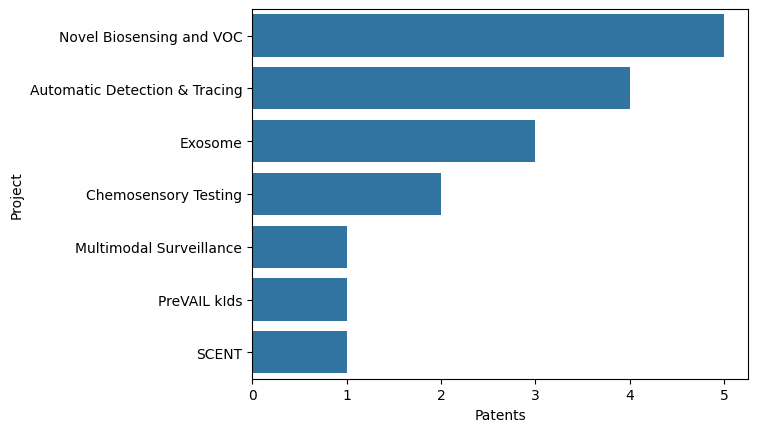

In [24]:
query = """
MATCH (p:Patent)<-[:IS_INVENTOR]-(:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN COUNT(DISTINCT p) AS Patents, g.subProject AS Project
ORDER BY Patents DESC
"""
patents = graph.run(query).to_data_frame()
sns.barplot(patents, x="Patents", y="Project");

### Patents with inventors from multiple RADx-rad grants

In [25]:
query = """
MATCH p=(g1:Grant)<-[:IS_INVESTIGATOR_OF]-(:Researcher)-[:IS_INVENTOR]->(:Patent)<-[:IS_INVENTOR]-(:Researcher)-[:IS_INVESTIGATOR_OF]-(g2:Grant) WHERE g1 <> g2 RETURN p
"""
subgraph5 = graph.run(query, researcher=researcher).to_subgraph()

In [26]:
widget5 = neo4j_utils.draw_graph(subgraph5, stylesheet)
widget5.layout.height = "900px"
widget5.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=5000)
widget5
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Software <a class="anchor" id="Software"></a>

In [27]:
query = """
MATCH (s:Software)<-[:DEVELOPED]-(r:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN s.name AS software, s.description AS description, s.url AS url, r.fullName AS developer, g.name AS grant
"""
graph.run(query).to_data_frame()

,software,description,url,developer,grant
0,dbgap-reporter,Jupyter Notebooks to analyze the number of data access requests for dbGaP datasets and publication including RADx datasets.,https://github.com/radxrad/dbgap-reporter,Peter W Rose,RADx-Rad Discoveries & Data: Consortium Coordination Center Program Organization
1,radx-kg,Knowledge Graph of Digital Assets from the NIH Rapid Acceleration of Diagnostics (RADx) initiative.,https://github.com/radxrad/radx-kg,Peter W Rose,RADx-Rad Discoveries & Data: Consortium Coordination Center Program Organization
2,covid-counter,Tools for counting covid sequences.,https://github.com/center4health/covid-counter,Rishi Graham,RADx-Rad Discoveries & Data: Consortium Coordination Center Program Organization
3,auspice_radx,Web app for visualizing pathogen evolution.,https://github.com/DBMI/auspice_radx,Kai Post,RADx-Rad Discoveries & Data: Consortium Coordination Center Program Organization
4,radx,RADx-rad pipeline for metagenomic data and analysis of SARS-CoV-2 from wastewater.,https://github.com/ZooPhy/radx,Matthew Scotch,Bioinformatics Framework for Wastewater-based Surveillance of Infectious Diseases


## Presentations <a class="anchor" id="Presentations"></a>
Presentations include poster presentations.

In [28]:
query = """
MATCH (p:Presentation) RETURN COUNT(p)
"""
print(f"Number of presentations: {graph.evaluate(query)}")

Number of presentations: 87


### Number of presentations by RADx-rad subprojects

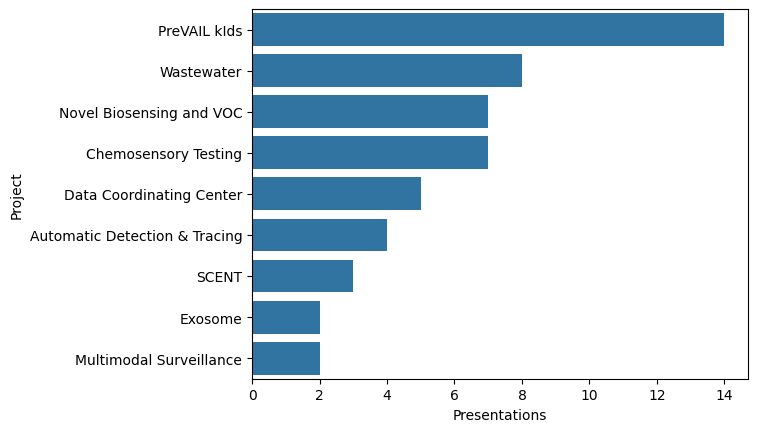

In [29]:
query = """
MATCH (p:Presentation)<-[:PRESENTED]-(:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN COUNT(DISTINCT p) AS Presentations, g.subProject AS Project
ORDER BY Presentations DESC
"""
presentations = graph.run(query).to_data_frame()
sns.barplot(presentations, x="Presentations", y="Project");

## Events <a class="anchor" id="Events"></a>

### Number of presentations per event

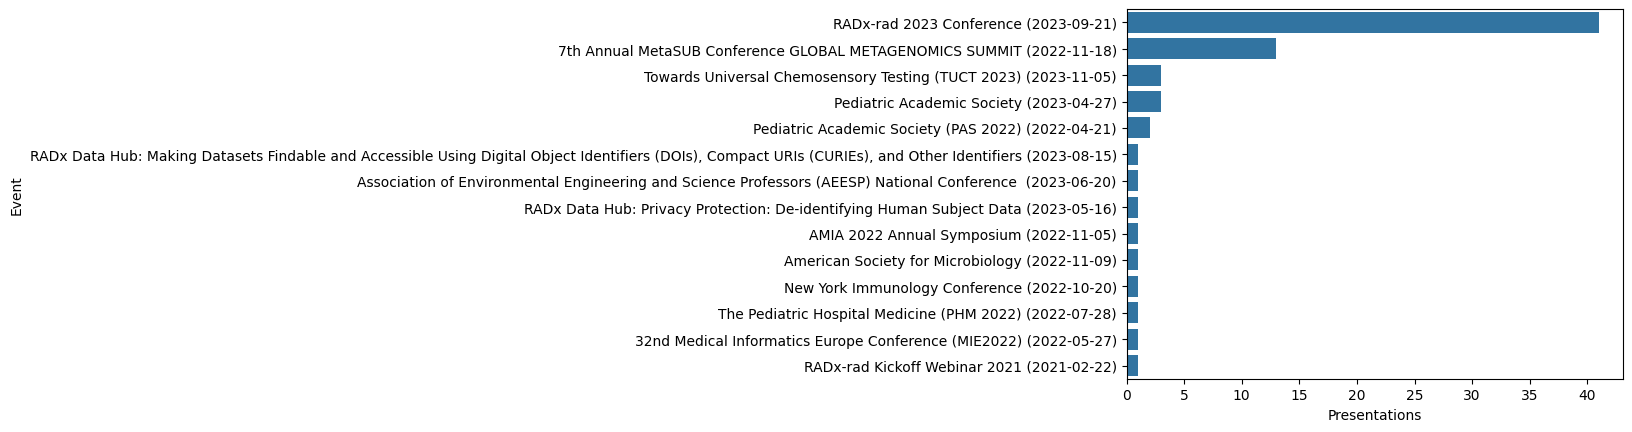

In [30]:
query = """
MATCH (e:Event)<-[:PRESENTED_AT]-(p:Presentation)<-[:PRESENTED]-(r:Researcher) RETURN e.name + " (" + e.startDate + ")" AS Event, COUNT(DISTINCT p) AS Presentations
ORDER BY Presentations DESC
"""
events = graph.run(query).to_data_frame()
sns.barplot(events, x="Presentations", y="Event");

## Organizations <a class="anchor" id="Organizations"></a>

### Grant PIs and their organizations

In [31]:
query = """
MATCH p=(o:Organization)<-[i:EMPLOYED_AT]-(r:Researcher)-[:IS_INVESTIGATOR_OF]->(g:Grant) RETURN p
"""
subgraph6 = graph.run(query).to_subgraph()

In [32]:
widget6 = neo4j_utils.draw_graph(subgraph6, stylesheet)
widget6.layout.height = "1000px"
widget6.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget6
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Funding Opportunities <a class="anchor" id="FundingOpportunities"></a>

In [33]:
query = """
MATCH p=(:FundingOpportunity)-[:PROVIDES]->(:Grant) RETURN p
"""
subgraph7 = graph.run(query).to_subgraph()

In [34]:
widget7 = neo4j_utils.draw_graph(subgraph7, stylesheet)
widget7.layout.height = "1000px"
widget7.set_layout(name="cola", padding=0, nodeSpacing=40, nodeDimensionsIncludeLabels=True, unconstrIter=15000)
widget7
# Click in the left cell margin and select "View output fullscreen" for a fullscreen view.
# Click in the left notebook margin and select "Take Screenshot" to save a screenshot.
# To improve the initial rendering of the graph, rerun this cell.

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'padding': 0, 'nodeSpacing': 40, 'nodeDimensionsIncludeLabel…

## Grants <a class="anchor" id="Grants"></a>

### Type of Grants

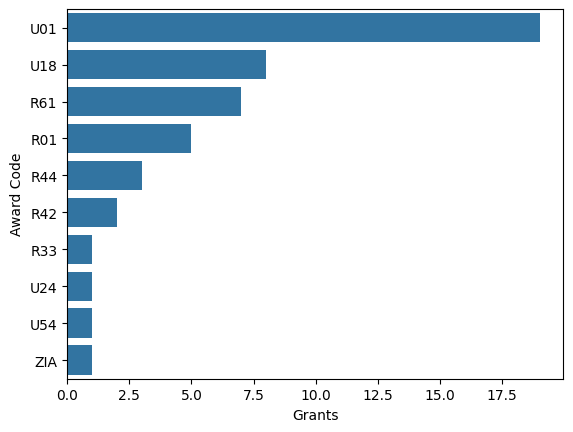

In [35]:
query = """
MATCH (g:Grant) RETURN g.awardCode AS `Award Code`, COUNT(DISTINCT g) AS Grants
ORDER BY Grants DESC, `Award Code`
"""
grants = graph.run(query).to_data_frame()
sns.barplot(grants, x="Grants", y="Award Code");

### Number of grants per state
If a grant has PIs in multiple states, each site is counted as a grant location.

In [36]:
query = """
MATCH (g:Grant)<-[:IS_INVESTIGATOR_OF]-(:Researcher)-[:EMPLOYED_AT]->(o:Organization) RETURN COUNT(DISTINCT g) as grants, o.state AS locations
"""
df = graph.run(query).to_data_frame()
px.choropleth(df, locations="locations", color="grants", locationmode="USA-states", scope="usa", color_continuous_scale="Reds", labels={"grants": "Grants"})

## Fulltext Search <a class="anchor" id="Fulltext Search"></a>

## Full text query by keyword or phrase
A full text query returns all nodes that match the text query ([Query Syntax](https://lucene.apache.org/core/5_5_0/queryparser/org/apache/lucene/queryparser/classic/package-summary.html#Overview)). For exact matches, enclose the phrase in double quotes, e.g., ```'"aptamer"'```.

[Learn more about full-text searches.](https://graphaware.com/neo4j/2019/01/11/neo4j-full-text-search-deep-dive.html)

In [37]:
phrase = '"aptamer"'

In [38]:
query = """
CALL db.index.fulltext.queryNodes("fulltext", $phrase) YIELD node, score
RETURN node.id AS id, LABELS(node)[0] AS type, node.name AS title, score
ORDER BY type
"""
graph.run(query, phrase=phrase).to_data_frame().head(15)

,id,type,title,score
0,dbgap:phs002702.v1.p1,Dataset,A Scalable Aptamer-based Electrochemical Biosensor For Rapid Detection of SARS-CoV-2 From Saliva,1.626665
1,R44DE030852,Grant,Designer DNA Nanostructure Based Biosensing for Rapid COVID19 Detection and Monitoring using Saliva Sample,3.182820
2,R44DE030842,Grant,A scalable aptamer-based electrochemical biosensor for rapid detection of SARS-CoV-2 from saliva,2.958715
3,R61HD105590,Grant,Diagnosing and predicting risk in children with SARS-CoV-2- related illness,1.713079
4,U01AA029316,Grant,"Touchscreen-compatible, real-time electrochemical sensing of SARS-CoV-2",1.517266
5,U01AA029328,Grant,Development of an Automated Diagnostic Platform for SARS-CoV-2 Monitoring in Vulnerable Areas,1.475827
6,U01AA029348,Grant,Detection and Automatic Privacy-Protected Contact Tracing System Designed for COVID-19,1.134879
7,982f2b070830a8bb88ace0042d0100db,Presentation,A Novel Aptamer-based Lateral Flow Assay to Detect SARS-CoV-2,1.831615
8,f10c31d02026ef92e1edd49fbd367226,Presentation,A scalable aptamer-based electrochemical biosensor for rapid detection of SARS--Cov-2 from Saliva,1.626665
9,doi:10.24425/pjvs.2023.145056,Publication,Application of aptamer-based viral detection in animals.,5.161030


## Full text query using boolean operators
The full text query supports a variety of query types, including fuzzy, proximity, and range queries, as well as boolean operators ([Query Syntax](https://lucene.apache.org/core/5_5_0/queryparser/org/apache/lucene/queryparser/classic/package-summary.html#Overview)). The following example uses a query with an ```AND``` operator.

In [39]:
phrase = 'aptamer AND biosensor'

In [40]:
query = """
CALL db.index.fulltext.queryNodes("fulltext", $phrase) YIELD node, score
RETURN node.id AS id, LABELS(node)[0] AS type, node.name AS title, score
ORDER BY type
"""
graph.run(query, phrase=phrase).to_data_frame()

,id,type,title,score
0,dbgap:phs002702.v1.p1,Dataset,A Scalable Aptamer-based Electrochemical Biosensor For Rapid Detection of SARS-CoV-2 From Saliva,3.466890
1,R44DE030842,Grant,A scalable aptamer-based electrochemical biosensor for rapid detection of SARS-CoV-2 from saliva,7.033527
2,U01AA029328,Grant,Development of an Automated Diagnostic Platform for SARS-CoV-2 Monitoring in Vulnerable Areas,5.787955
3,U01AA029316,Grant,"Touchscreen-compatible, real-time electrochemical sensing of SARS-CoV-2",4.910275
4,R44DE030852,Grant,Designer DNA Nanostructure Based Biosensing for Rapid COVID19 Detection and Monitoring using Saliva Sample,4.350326
5,f10c31d02026ef92e1edd49fbd367226,Presentation,A scalable aptamer-based electrochemical biosensor for rapid detection of SARS--Cov-2 from Saliva,3.466890
6,doi:10.1021/acs.analchem.2c04709,Publication,T-Shaped Aptamer-Based LSPR Biosensor Using Ω-Shaped Fiber Optic for Rapid Detection of SARS-CoV-2,8.378041
7,doi:10.3390/bios13121027,Publication,A Novel Aptamer Biosensor Based on a Localized Surface Plasmon Resonance Sensing Chip for High-Sensitivity and Rapid Enrofloxacin Detection,7.881639
8,doi:10.3390/s23229139,Publication,Divalent Aptamer-Functionalized Nanochannels for Facile Detection of Cancer Cell-Derived Exosomes,7.099707
9,doi:10.3390/bios14010056,Publication,Sensing Levofloxacin with an RNA Aptamer as a Bioreceptor,6.697842


In [41]:
query = """
CALL db.index.vector.createNodeIndex("publications", "Publication", "embedding", 768, "cosine");
"""
graph.run(query, phrase=phrase).to_data_frame()
#print(f"{graph.evaluate(query)}")

""


In [42]:
query = """
SHOW INDEXES YIELD id, name, type, state, populationPercent WHERE type = "VECTOR"
"""
graph.run(query).to_data_frame()

,id,name,type,state,populationPercent
0,82,publications,VECTOR,POPULATING,42.89064


## Semanic Search to find similar Publications
Search for publications that are similar to the MIS-C publication: doi:10.3390/jcm12175435" based on the title and abstract.

The similarity between two publications is cosine-similarity between the embeddings of the title and abstract. The text embeddings are calculated using [SPECTER](https://arxiv.org/abs/2004.07180): Document-level Representation Learning using Citation-informed Transformers.

In [43]:
publication = "doi:10.3390/jcm12175435" # "Stratification of Pediatric COVID-19 Cases Using Inflammatory Biomarker Profiling and Machine Learning."
#publication = "doi:10.1101/2022.03.14.22272314" # "COVID-19 Prediction using Genomic Footprint of SARS-CoV-2 in Air, Surface Swab and Wastewater Samples."
top_n = 5 # show the top n results
similarity_threshold = 0.8 # show results with a similarity >= 0.8

In [44]:
query = """
MATCH (p:Publication {id: $id})
CALL db.index.vector.queryNodes('publications', $top_n, p.embedding)
YIELD node, score
WHERE score >= $similarity_threshold
RETURN node.name AS title, node.abstract AS abstract, score AS similarity
"""
graph.run(query, id=publication, top_n=top_n, similarity_threshold=similarity_threshold).to_data_frame()

,title,abstract,similarity
0,Stratification of Pediatric COVID-19 Cases Using Inflammatory Biomarker Profiling and Machine Learning.,"While pediatric COVID-19 is rarely severe, a small fraction of children infected with SARS-CoV-2 go on to develop multisystem inflammatory syndrome (MIS-C), with substantial morbidity. An objective method with high specificity and high sensitivity to identify current or imminent MIS-C in children infected with SARS-CoV-2 is highly desirable. The aim was to learn about an interpretable novel cytokine/chemokine assay panel providing such an objective classification. This retrospective study was conducted on four groups of pediatric patients seen at multiple sites of Texas Children's Hospital, Houston, TX who consented to provide blood samples to our COVID-19 Biorepository. Standard laboratory markers of inflammation and a novel cytokine/chemokine array were measured in blood samples of all patients. Group 1 consisted of 72 COVID-19, 70 MIS-C and 63 uninfected control patients seen between May 2020 and January 2021 and predominantly infected with pre-alpha variants. Group 2 consisted of 29 COVID-19 and 43 MIS-C patients seen between January and May 2021 infected predominantly with the alpha variant. Group 3 consisted of 30 COVID-19 and 32 MIS-C patients seen between August and October 2021 infected with alpha and/or delta variants. Group 4 consisted of 20 COVID-19 and 46 MIS-C patients seen between October 2021 andJanuary 2022 infected with delta and/or omicron variants. Group 1 was used to train an L1-regularized logistic regression model which was tested using five-fold cross validation, and then separately validated against the remaining naïve groups. The area under receiver operating curve (AUROC) and F1-score were used to quantify the performance of the cytokine/chemokine assay-based classifier. Standard laboratory markers predict MIS-C with a five-fold cross-validated AUROC of 0.86 ± 0.05 and an F1 score of 0.78 ± 0.07, while the cytokine/chemokine panel predicted MIS-C with a five-fold cross-validated AUROC of 0.95 ± 0.02 and an F1 score of 0.91 ± 0.04, with only sixteen of the forty-five cytokines/chemokines sufficient to achieve this performance. Tested on Group 2 the cytokine/chemokine panel yielded AUROC = 0.98 and F1 = 0.93, on Group 3 it yielded AUROC = 0.89 and F1 = 0.89, and on Group 4 AUROC = 0.99 and F1 = 0.97. Adding standard laboratory markers to the cytokine/chemokine panel did not improve performance. A top-10 subset of these 16 cytokines achieves equivalent performance on the validation data sets. Our findings demonstrate that a sixteen-cytokine/chemokine panel as well as the top ten subset provides a highly sensitive, and specific method to identify MIS-C in patients infected with SARS-CoV-2 of all the major variants identified to date.",1.000000
1,Deep immune profiling of MIS-C demonstrates marked but transient immune activation compared to adult and pediatric COVID-19.,"Pediatric COVID-19 following SARS-CoV-2 infection is associated with fewer hospitalizations and often milder disease than in adults. A subset of children, however, present with Multisystem Inflammatory Syndrome in Children (MIS-C) that can lead to vascular complications and shock, but rarely death. The immune features of MIS-C compared to pediatric COVID-19 or adult disease remain poorly understood. We analyzed peripheral blood immune responses in hospitalized SARS-CoV-2 infected pediatric patients (pediatric COVID-19) and patients with MIS-C. MIS-C patients had patterns of T cell-biased lymphopenia and T cell activation similar to severely ill adults, and all patients with MIS-C had SARS-CoV-2 spike-specific antibodies at admission. A distinct feature of MIS-C patients was robust activation of vascular patrolling CX3CR1+ CD8+ T cells that correlated with the use of vasoactive medication. Finally, whereas pediatric COVID-19 patients with acute respiratory distress syndrome (ARDS) had sustained immune activat

### Shutdown Neo4j before closing this notebook.
If you run this notebook locally, uncomment the last line and run neo4j_utils.stop() to stop the database. Otherwise, the database server will keep running.

In [45]:
#neo4j_utils.stop()